## Imports and Configurations

In [1]:
import os.path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import random
import scipy.misc
import time
import shutil
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Lambda
from keras.layers.core import Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.


In [70]:
# Configurations here

flags = {
    'mirror_data': False,
    'augment_data': True,
    'train_model': True,
    'show_plots': True,
    'show_images': False,
    'downsample_straight': False,
    'model': 'nvidia'
}

## Load and Preprocess Data

#### Data Augmentation and Balancing

In [60]:
def augment_brightness(image):
    # Randomly select a percentage change
    random_bright = 0.25 + np.random.uniform()
    
    # Change to HSV to change the brightness V
    image_augmented = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_augmented[:,:,2] = image_augmented[:,:,2]*random_bright
    
    # Convert back to RGB
    image_augmented = cv2.cvtColor(image_augmented,cv2.COLOR_HSV2RGB)
    return image_augmented

def mirror_image(image, angle):
    image_mirrored = cv2.flip(image,1)
    angle = -angle
    return image_mirrored, angle

def perturb_angle(angle):
    new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
    return new_angle

In [61]:
if flags['mirror_data']:
    start = time.time()
    
    df = pd.read_csv('data/udacity_data/driving_log.csv')
    df_mirror = pd.DataFrame(columns=df.columns, index=df.index)
    for index, row in df.iterrows():
        image = mpimg.imread('data/udacity_data/' + row['center'])
        angle = row['steering']
        image, angle = mirror_image(image, angle)
        df_mirror.loc[index] = df.iloc[index].values
        df_mirror.set_value(index, 'steering', angle)
        filename = 'IMG/mirrored_{0}.jpg'.format(index)
        filepath = 'data/mirrored_data/' + filename
        df_mirror.set_value(index, 'center', filename)
        scipy.misc.imsave(filepath, image)
    
    df_mirror.to_csv('data/mirrored_data/driving_log.csv', index=False)
    end = time.time()
    print("Execution Time (s): ", end - start)

In [62]:
if flags['augment_data']:
    print("Creating Augmented Data...")
    start = time.time()

    # Load training data
    offset = 0
    df_udacity = pd.read_csv('data/udacity_data/driving_log.csv')
#     df_mirror = pd.read_csv('data/mirrored_data/driving_log.csv')
#     df = pd.concat((df_udacity, df_mirror))
    df = df_udacity
    df.reset_index(drop=True, inplace=True)
    df_aug = pd.DataFrame(columns=df.columns, index=df.index)

    # Create and save augmented images
    y_train = df['steering'].values
    turn_indexes = ([i for i,v in enumerate(y_train) if v != 0])

    for j in range(9000): # This number determines how many images we generate
        index = np.random.choice(turn_indexes)
        mirror = bool(random.randint(0,1))
        perturb = bool(random.randint(0,1))
        brighten = bool(random.randint(0,1))
        
        path = df.iloc[index]['center']
        if 'mirrored' in path:
            path = 'data/mirrored_data/' + path
        else:
            path = 'data/udacity_data/' + path
        image = mpimg.imread(path)
        angle = df.iloc[index]['steering']
        
        if mirror:
            image, angle = mirror_image(image, angle)
        if perturb:
            angle = perturb_angle(angle)
        if brighten:
            image = augment_brightness(image)
        
        df_aug.loc[j] = df.iloc[index].values
        df_aug.set_value(j, 'steering', angle)
        filename = 'IMG/augmented_{0}.jpg'.format(j)
        filepath = 'data/augmented_data/' + filename
        df_aug.set_value(j, 'center', filename)
        scipy.misc.imsave(filepath, image)
        if j % 1000 == 0:
            print('{} images complete'.format(j))
    
    df_aug.dropna().to_csv('data/augmented_data/driving_log.csv', index=False)
    end = time.time()
    print("Execution Time (secs):", end - start)

Creating Augmented Data...
0 images complete
1000 images complete
2000 images complete
3000 images complete
4000 images complete
5000 images complete
6000 images complete
7000 images complete
8000 images complete
Execution Time (secs): 56.80866503715515


#### Load Data

In [63]:
df_udacity = pd.read_csv('data/udacity_data/driving_log.csv')
df_mirror = pd.read_csv('data/mirrored_data/driving_log.csv')
df_aug = pd.read_csv('data/augmented_data/driving_log.csv')
df_mine = pd.read_csv('data/my_driving_data/driving_log.csv')
df = pd.concat((df_udacity, df_aug, df_mine))
df.reset_index(drop=True, inplace=True)
df.tail()

,center,left,right,steering,throttle,brake,speed
19739,IMG/center_2017_02_02_16_55_28_644.jpg,IMG/left_2017_02_02_16_55_28_644.jpg,IMG/right_2017_02_02_16_55_28_644.jpg,0.0,0.0,0.0,4.196266
19740,IMG/center_2017_02_02_16_55_28_747.jpg,IMG/left_2017_02_02_16_55_28_747.jpg,IMG/right_2017_02_02_16_55_28_747.jpg,0.0,0.0,0.0,4.152821
19741,IMG/center_2017_02_02_16_55_28_850.jpg,IMG/left_2017_02_02_16_55_28_850.jpg,IMG/right_2017_02_02_16_55_28_850.jpg,0.0,0.0,0.0,4.109815
19742,IMG/center_2017_02_02_16_55_28_954.jpg,IMG/left_2017_02_02_16_55_28_954.jpg,IMG/right_2017_02_02_16_55_28_954.jpg,0.0,0.0,0.0,4.067245
19743,IMG/center_2017_02_02_16_55_29_062.jpg,IMG/left_2017_02_02_16_55_29_062.jpg,IMG/right_2017_02_02_16_55_29_062.jpg,0.0,0.0,0.0,4.016730


In [65]:
if flags['downsample_straight']:
    keep_num = 6000
    straight_indexes = df[df.steering == 0].index
    drop_indexes = np.random.choice(straight_indexes, len(straight_indexes) - keep_num , replace=False)
    df.drop(drop_indexes, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(df.tail())

In [66]:
# Split and shuffle data
num_examples = df['center'].count()
indexes = np.arange(0, num_examples)
# np.random.shuffle(indexes)
train_indexes, val_indexes = train_test_split(indexes, test_size=0.2)
df_train = df.loc[train_indexes]
df_val = df.loc[val_indexes]

#### Plots

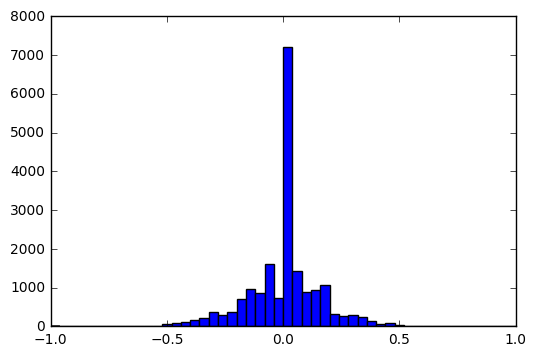

In [67]:
if flags['show_plots']:    
    plt.hist(df['steering'], bins=50)

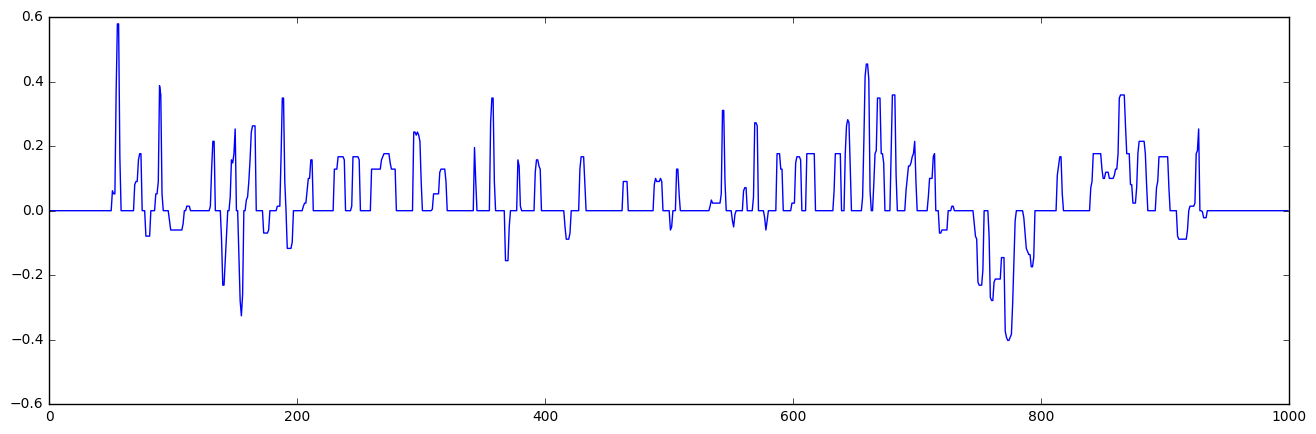

In [68]:
if flags['show_plots']:
    plt.figure(figsize=(16,5))
    plt.plot(df['steering'].values[0:1000])

In [71]:
if flags['show_images']:
    for i in range(3):
        index = np.random.choice(df_udacity.index)
        filename = 'data/udacity_data/' + df_udacity['center'][index]
        image = mpimg.imread(filename)
        plt.figure()
        plt.imshow(image)

## Setup and Train Network

#### Data Generator

In [72]:
def train_generator(df):
    while True:
        batch_indexes = np.random.choice(df.index, 128, replace=False)
        batch = df.loc[batch_indexes]
        images = []
        for index, row in batch.iterrows():
            filename = row['center']
            if 'augmented' in filename:
                path = 'data/augmented_data/' + filename
            elif 'mirrored' in filename:
                path = 'data/mirrored_data/' + filename
            elif '2017_02_02' in filename:
                path = 'data/my_driving_data/' + filename
            else:
                path = 'data/udacity_data/' + filename
            image = mpimg.imread(path)
            image = cv2.resize(image, (200, 66))
            image = image[np.newaxis, ...]
            images.append(image)
        batch_x = np.concatenate(images, axis=0)
        batch_y = batch['steering'].values
        yield batch_x, batch_y

#### Model and Training

In [73]:
if flags['model'] == 'alexnet':
    model = Sequential()
    
    # Normalize
    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(227, 227, 3)))
    
    # Output = 55 x 55
    model.add(Convolution2D(48, 11, 11, subsample=(4,4)))
    model.add(Activation('relu'))
    
    # Output = 27 x 27
    model.add(MaxPooling2D((3,3), strides=(2,2)))
    model.add(Convolution2D(128, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    
    # Output = 13 x 13
    model.add(MaxPooling2D((3,3), strides=(2,2)))
    model.add(Convolution2D(192, 3, 3, border_mode='same'))
    model.add(Activation('relu'))

    # Output = 13 x 13
    model.add(Convolution2D(192, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    
    # Output = 13 x 13
    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    
    # Output = 4 x 4 x 128
    model.add(MaxPooling2D((3,3)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(128))
    model.add(Dense(32))
    model.add(Dense(1))

In [74]:
if flags['model'] == 'nvidia':
    model = Sequential()

    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=(66, 200, 3)))
    
    model.add(Convolution2D(24, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(36, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 5, 5, subsample=(2,2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1))

In [76]:
if flags['train_model']:
    start = time.time()
    adam = Adam(lr=0.0003)
    model.compile(loss='mse', optimizer=adam)
    model.fit_generator(train_generator(df_train), samples_per_epoch=16000, 
                        nb_epoch=5, validation_data=train_generator(df_val), nb_val_samples=3968)
    model.save('model.h5')
    end = time.time()
    print("Training Time (s)", end - start)

Epoch 1/5
16000/16000 [==============================] - 36s - loss: 0.0149 - val_loss: 0.0132
Epoch 2/5
16000/16000 [==============================] - 33s - loss: 0.0140 - val_loss: 0.0127
Epoch 3/5
16000/16000 [==============================] - 33s - loss: 0.0138 - val_loss: 0.0133
Epoch 4/5
16000/16000 [==============================] - 33s - loss: 0.0150 - val_loss: 0.0116
Epoch 5/5
16000/16000 [==============================] - 33s - loss: 0.0128 - val_loss: 0.0129
Training Time (s) 172.7745659351349
